# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## 0. Define the parameters of the model (0.5 pts)

In [2]:
# INSERT CODE HERE
mean_1 = 4
mean_2 = 6
scale = 1

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [3]:
# INSERT CODE BELOW
def post_distr(c, mean_prior_1=mean_1, mean_prior_2=mean_2, scale_prior=scale):
    # Defining prior distributions
    prior_1 = norm.pdf(c, loc=mean_prior_1, scale=scale_prior)
    prior_2 = norm.pdf(c, loc=mean_prior_2, scale=scale_prior)

    # likelihood ratio
    l_c_1 = prior_1 / prior_2
    l_c_2 = prior_2 / prior_1

    # Posterior distribution
    post_distr_1 = 1 / (1+ (1/l_c_2) )
    post_distr_2 = 1 / (1+ (1/l_c_1) )

    return post_distr_1, post_distr_2

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

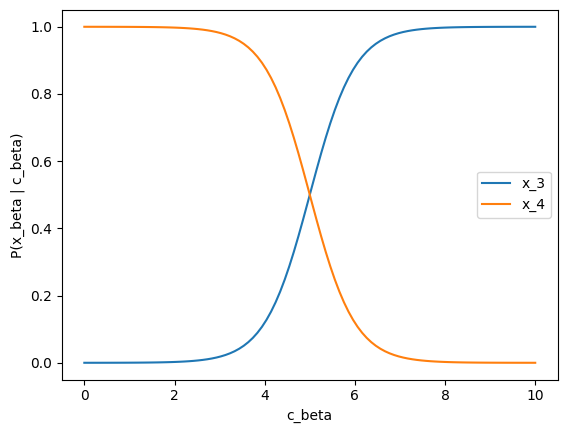

In [4]:
# INSERT CODE BELOW
cues = np.linspace(0,10,100)

posterior_1 = []
posterior_2 = []

for c in cues:
    post_distr_1, post_distr_2 = post_distr(c)
    posterior_1.append(post_distr_1)
    posterior_2.append(post_distr_2)

plt.plot(cues, posterior_1, label='x_3')
plt.plot(cues, posterior_2, label='x_4')
plt.xlabel("c_beta")
plt.ylabel("P(x_beta | c_beta)")
plt.legend()
plt.show()

INSERT ANSWER BELOW  
The plot shows the posterior distributions that are the belief state based on the cue $c_{\beta}$. From the plot we can see the of the cue  $c_{\beta}$ signalling the state $x_3$ and $x_4$. For $c_{\beta} = 5$ we are unsure which state the cue is signalling. For higher/smaller $c_{\beta}$ we are able to make better state predictions based on the cue.

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [5]:
# INSERT CODE BELOW
def update_post(c_alpha, c_beta, mean_prior_1=mean_1, mean_prior_2=mean_2, scale_prior=scale):
    # Get the initial belief state based on the first cue (c_alpha)
    post_distr_x1_alpha, post_distr_x2_alpha = post_distr(c_alpha, mean_prior_1, mean_prior_2, scale_prior)
    post_distr_x3_beta, post_distr_x4_beta = post_distr(c_beta, mean_prior_1, mean_prior_2, scale_prior)

    post_distr_x1_alpha_beta = post_distr_x1_alpha * post_distr_x3_beta
    post_distr_x2_alpha_beta = post_distr_x2_alpha * post_distr_x4_beta

    post_distr_x1_alpha_beta = post_distr_x1_alpha_beta / (post_distr_x1_alpha_beta + post_distr_x2_alpha_beta)
    post_distr_x2_alpha_beta = post_distr_x2_alpha_beta / (post_distr_x1_alpha_beta + post_distr_x2_alpha_beta)

    return post_distr_x1_alpha_beta

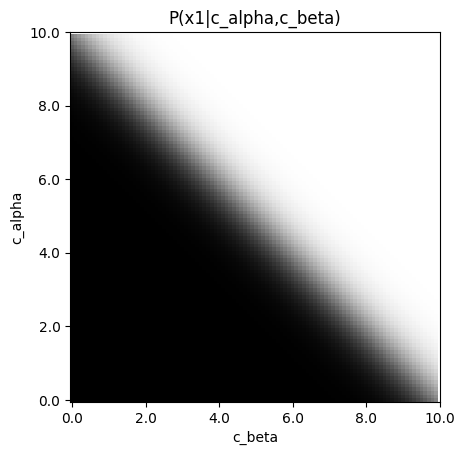

In [6]:
cues = np.linspace(0,10,100)

beliefs = np.zeros(shape=(100,100))
for c_beta in range(cues.shape[0]):
    for c_alpha in range(cues.shape[0]):
        beliefs[c_beta,c_alpha] = update_post(c_alpha=cues[c_alpha], c_beta=cues[c_beta])


plt.imshow(beliefs, cmap='gray', origin='lower')
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(100//10), ticks)
plt.yticks(ticks*(100//10), ticks)
plt.xlabel("c_beta")
plt.ylabel("c_alpha")
plt.title("P(x1|c_alpha,c_beta)")
plt.show()

INSERT ANSWER BELOW  
The plot shows the posterior distribution on which the belief state is based on. In this scenario the plot shows the certainty of being state 1, with the whith the pixels representing a high likelihood of being in state 1 (-> white = 1) and the black pixels a low likelihood (black=0). The gray pixels identify the cases with a high uncertainty of the belief state. In these cases in the diagonal of the plot, the belief state is unsure whether the current state is state 1 or 2.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

INSERT ANSWER BELOW  
Other than the initial stage, the final stage always leads to an immediate reward. To update the policy, we try to maximize the final reward by doing a kind of backpropagation.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

In [7]:
# INSERT CODE BELOW
def v_optimal(post_1, post_2):
    return np.maximum(post_1, post_2)

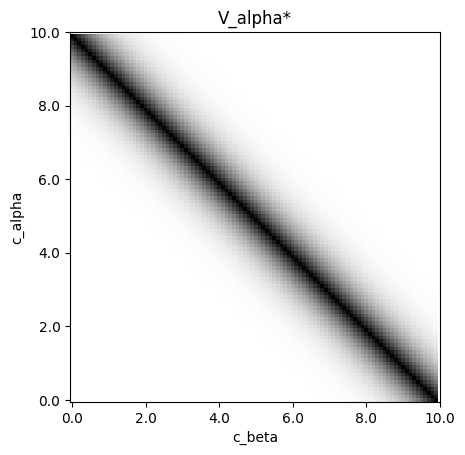

In [8]:
cues = np.linspace(0,10,100)

beliefs = np.zeros(shape=(100,100))
values = np.zeros(shape=(100,100))

for c_beta in range(cues.shape[0]):
    for c_alpha in range(cues.shape[0]):
        beliefs[c_beta,c_alpha] = update_post(c_alpha=cues[c_alpha], c_beta=cues[c_beta])
        values[c_beta,c_alpha] = v_optimal(beliefs[c_beta,c_alpha], 1-beliefs[c_beta,c_alpha])


plt.imshow(values, cmap='gray', origin='lower')
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(100//10), ticks)
plt.yticks(ticks*(100//10), ticks)
plt.xlabel("c_beta")
plt.ylabel("c_alpha")
plt.title("V_alpha*")
plt.show()

INSERT ANSWER BELOW  
The value is high (white) when $c_\alpha$ and $c_\beta$ are such that the subject can be rather sure whether $x_\alpha = x_1$ or $x_\alpha = x_2$, meaning that the belief state has minimal uncertainty and one of posterior distributions $P(x_1 | c_\alpha, c_\beta)$ and $P(x_1 | c_\alpha, c_\beta)$ is close to 1 and the other close to 0. In these cases it is unambigious which action to perform. If, instead, the cues are inconsistent, the value is closer to .5, which is that of random guessing. Therefore, we get the black diagonal line in the plot indicaring a $V_\alpha^*$ of 0.5 .

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW  
The probability $P(c_{\alpha} | c_{\beta})$ indicates how likely it is to observe $c_{\alpha}$ given $c_{\beta}$. This probability helps in updating the belief about the current state based on the new information, allowing the agent to refine its prediction about which state it is in and what the best action might be.



### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

In [11]:
# INSERT CODE BELOW
def prob_c_alpha_given_c_beta(c_alpha, c_beta):

    prob_c_alpha_given_x1 = norm.pdf(c_alpha, loc=mean_1, scale=scale)
    prob_c_alpha_given_x2 = norm.pdf(c_alpha, loc=mean_2, scale=scale)
    prob_c_beta_given_x3 = norm.pdf(c_beta, loc=mean_1, scale=scale)
    prob_c_beta_given_x4 = norm.pdf(c_beta, loc=mean_2, scale=scale)

    prob_c_alpha_c_beta = prob_c_alpha_given_x1 * prob_c_beta_given_x3 + prob_c_alpha_given_x2 * prob_c_beta_given_x4
    prob_c_beta = 0.5 * (prob_c_beta_given_x3 + prob_c_beta_given_x4)
    prob_c_alpha_given_c_beta = prob_c_alpha_c_beta / prob_c_beta
    return prob_c_alpha_given_c_beta


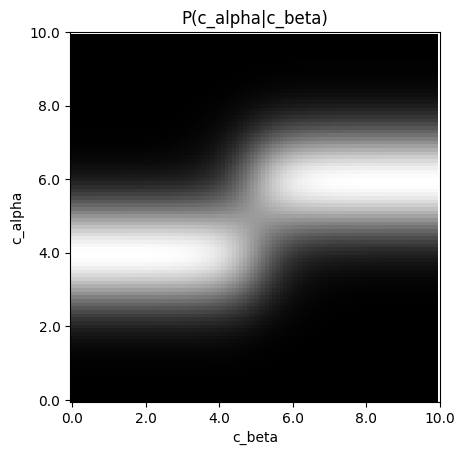

In [12]:
cues = np.linspace(0,10,100)

probs = np.zeros(shape=(100,100))

for c_beta in range(cues.shape[0]):
    for c_alpha in range(cues.shape[0]):
        probs[c_beta,c_alpha] = prob_c_alpha_given_c_beta(c_alpha=cues[c_alpha], c_beta=cues[c_beta])

for c_alpha in range(cues.shape[0]):
    for c_beta in range(cues.shape[0]):
        probs[c_alpha,c_beta] = prob_c_alpha_given_c_beta(c_alpha=cues[c_alpha], c_beta=cues[c_beta])



plt.imshow(probs, cmap='gray', origin='lower')
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(100//10), ticks)
plt.yticks(ticks*(100//10), ticks)
plt.xlabel("c_beta")
plt.ylabel("c_alpha")
plt.title("P(c_alpha|c_beta)")
plt.show()

INSERT ANSWER BELOW  
We can compute the $P(c_\alpha | c_\beta)$ by apllying $P(y|x) P(x) = P(x,y)$ and using Bayes' theorem:
\begin{align}
P(c_\alpha | c_\beta) = \frac{P(c_\alpha, c_\beta)}{P(c_\beta)}.
\end{align}
The plot shows the probabilities of observing the cue $c_\alpha$ given the cue $c_\beta$. For $0 < c_\beta < 5$ and $2 < c_\alpha < 6$ we can observe a high likelihood as well as for $5 < c_\beta < 10$ and $4 < c_\alpha < 8$. We can see that for $c_\beta < 5$ it is most likely to observe $c_\alpha=4$ and for $c_\beta > 5, c_\alpha = 6$, which correlates with the mean of the distributions. However, it is to mention that around $c_\beta = 5$ the model is unsure from which distribution the cue orriginates from.

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

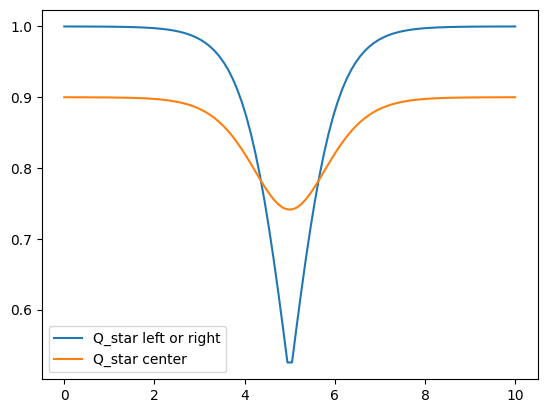

[4.34343434 5.55555556]


In [35]:
# INSERT CODE BELOW
r_c = -0.1
cues = np.linspace(0,10,100)


def q_value(c_beta, idx_beta):

    q_val = np.zeros(2)
    prob_x3_c_beta, prob_x4_c_beta = post_distr(c_beta)

    # Left/right
    q_val[0] = v_optimal(prob_x3_c_beta, prob_x4_c_beta)


    # Center
    q_val[1] = r_c + np.sum(values[:, idx_beta] * probs[:, idx_beta]) / np.sum(probs[:, idx_beta])

    return q_val


q_vals_lr = []
q_vals_c = []
for i, c_beta in enumerate(cues):
    q_vals = q_value(c_beta, i)
    q_vals_lr.append(q_vals[0])
    q_vals_c.append(q_vals[1])


plt.plot(cues, q_vals_lr, label = 'Q_star left or right')
plt.plot(cues, q_vals_c, label = 'Q_star center')
plt.legend()
plt.show()

# Calculate the difference and find where the sign changes
diff = np.array(q_vals_lr) - np.array(q_vals_c)
indices = np.argwhere(np.diff(np.sign(diff))).flatten()

# Get the alpha-values at the points of intersection
intersect = cues[indices]
print(intersect)

INSERT ANSWER BELOW  
We can observe that $4.34 < c_\beta < 5.55$ it is the better to choose the center option and it is better for all other cue values to make an immediate decision. This is because in the cases in which the cue is very ambigious, it is preferable to observe a second cue and not only rely on the first cue. In these cases the gain from the second cue outweight the cost of choosing the center option.

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

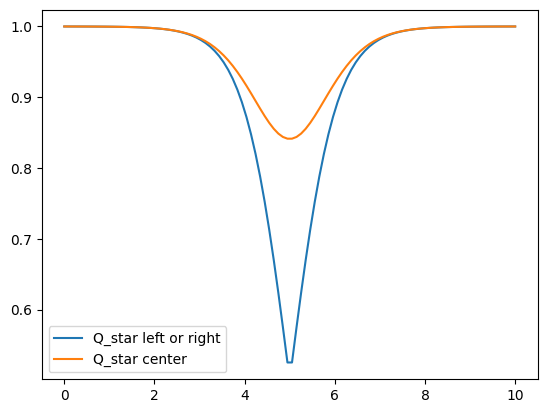

In [30]:
# INSERT CODE BELOW

# Always better to chooose center

r_c_2 = 0
cues = np.linspace(0,10,100)


def q_value(c_beta, idx_beta):

    q_val = np.zeros(2)
    prob_x3_c_beta, prob_x4_c_beta = post_distr(c_beta)

    # Left/right
    q_val[0] = v_optimal(prob_x3_c_beta, prob_x4_c_beta)


    # Center
    q_val[1] = r_c_2 + np.sum(values[:, idx_beta] * probs[:, idx_beta]) / np.sum(probs[:, idx_beta])

    return q_val


q_vals_lr = []
q_vals_c = []
for i, c_beta in enumerate(cues):
    q_vals = q_value(c_beta, i)
    q_vals_lr.append(q_vals[0])
    q_vals_c.append(q_vals[1])


plt.plot(cues, q_vals_lr, label = 'Q_star left or right')
plt.plot(cues, q_vals_c, label = 'Q_star center')
plt.legend()
plt.show()

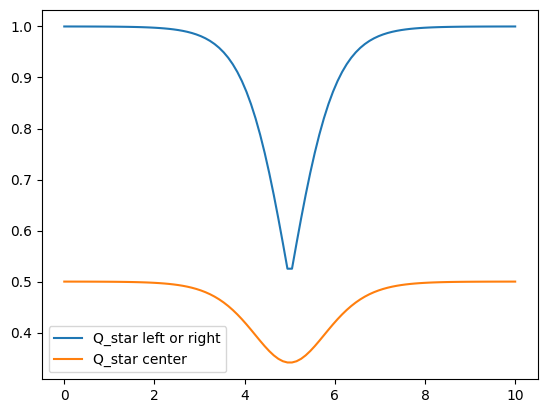

In [32]:
# INSERT CODE BELOW

# never better to chooose center

r_c_3 = -0.5
cues = np.linspace(0,10,100)


def q_value(c_beta, idx_beta):

    q_val = np.zeros(2)
    prob_x3_c_beta, prob_x4_c_beta = post_distr(c_beta)

    # Left/right
    q_val[0] = v_optimal(prob_x3_c_beta, prob_x4_c_beta)


    # Center
    q_val[1] = r_c_3 + np.sum(values[:, idx_beta] * probs[:, idx_beta]) / np.sum(probs[:, idx_beta])

    return q_val


q_vals_lr = []
q_vals_c = []
for i, c_beta in enumerate(cues):
    q_vals = q_value(c_beta, i)
    q_vals_lr.append(q_vals[0])
    q_vals_c.append(q_vals[1])


plt.plot(cues, q_vals_lr, label = 'Q_star left or right')
plt.plot(cues, q_vals_c, label = 'Q_star center')
plt.legend()
plt.show()

INSERT ANSWER BELOW

The easiest adaptation to influence the agent to choose the center option more/less frequently is to decrease/increase the punishment of choosing the center option (as seen above).  
Moreover, one could make the two distributions more similar such that the cues become more ambiguous and sampling for a second time becomes more relavant. The same argument also holds in the opposite way when making the the two distributions less similar.  
Another option is to make the rewards bigger/smaller while keeping the cost of choosing center at -0.1. This way the cost in relation to the reward becomes smaller/bigger and one chooses more/less often the center option.